# Trust Region Policy Optimization (TRPO) - Policy Gradient

## Preparation

Import packages

In [2]:
%%capture
import matplotlib.pyplot as plt
import pyvirtualdisplay
import numpy as np
import IPython
import torch
import tqdm
import gym
%matplotlib inline

Set up the virtual display

In [3]:
virtual_display = pyvirtualdisplay.Display(visible=0, size=(1400,900))
virtual_display.start()

Set up the gym environment

In [4]:
env = gym.make(
    "LunarLander-v2",
    continuous=True,
    render_mode="rgb_array"
)

Report the observation space and action space

In [5]:
print(env.observation_space)
print(env.action_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Box(-1.0, 1.0, (2,), float32)


Reset the environment

In [6]:
initial_state = env.reset()
print(initial_state)

(array([ 0.00330496,  1.4093542 ,  0.33473545, -0.06959347, -0.00382278,
       -0.07582258,  0.        ,  0.        ], dtype=float32), {})


## Random Agent

Verify the environment setup

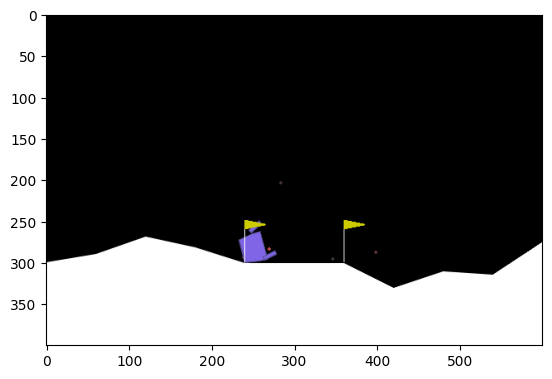

In [8]:
img = plt.imshow(env.render())

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _, _ = env.step(action)
    
    img.set_data(env.render())
    IPython.display.display(plt.gcf())
    IPython.display.clear_output(wait=True)

## Policy Network

In [14]:
class PolicyGradientNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(8,16)
        self.fc2 = torch.nn.Linear(16,16)
        self.fc3 = torch.nn.Linear(16,2)
        
    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return torch.tanh(self.fc3(hid))

## Policy Gradient Agent

In [89]:
class PolicyGradientAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=0.001)
        
    def learn(self, log_probs, rewards):
        pass
    
    def sample(self, state):
        action = self.network(torch.FloatTensor(state))
        return action.tolist(), 0

Initialize the network and the agent

In [90]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Training

Set the network to trianing mode to enable gradient tracking

In [91]:
agent.network.train()

PolicyGradientNetwork(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Initialize training hyperparameters

In [92]:
EPISODE_PER_BATCH = 5
NUM_BATCH = 400

Train the agent

In [93]:
avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm.notebook.tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    # Collect training data
    for episode in range(EPISODE_PER_BATCH):
        state, _ = env.reset()
        total_reward, total_step = 0, 0
        while True:
            action, log_prob = agent.sample(state)
            next_state, reward, done, _, _ = env.step(action)
            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                rewards.append(np.full(total_step, total_reward))  # Set the same episode, and the reward of each action is total reward
                break
    # Record the training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Update the network
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # Normalize reward


  0%|          | 0/400 [00:00<?, ?it/s]